In [1]:
!python3 -m spacy download en
!python3 -m spacy download es

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2
!pip install tqdm==4.62.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 89.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 9.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━

In [3]:
!pip install tqdm==4.62.3

In [4]:
import os
import gc
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
import es_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import evaluate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

In [5]:
# load language models
en_nlp = en_core_web_sm.load()
es_nlp = es_core_news_sm.load()

In [6]:
# set random seed to obtain the same results
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
from datasets import load_dataset

ds = load_dataset("Helsinki-NLP/europarl", "en-es")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2009073 [00:00<?, ? examples/s]

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2009073
    })
})

In [9]:
# split on train, test, valid datasets
train_size = 8000
valid_size = 200
test_size = 200


# first, split the dataset into train (train + valid) and test
train_test_split = ds['train'].train_test_split(
    train_size=train_size,
    test_size=test_size
)

# now, split the 'train' part again into train and valid
train_valid_split = train_test_split['train'].train_test_split(test_size=valid_size)

train_data = train_valid_split['train'] # 8000
valid_data = train_valid_split['test'] # 200
test_data = train_test_split['test'] # 200

In [10]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(7800, 1)
(200, 1)
(200, 1)


In [11]:
print(train_data['translation'][0])
print(valid_data['translation'][0])
print(test_data['translation'][0])

{'en': 'It seems to me that if the innovation is valid for that convention, it would be a good thing to make use of it for this one too.', 'es': 'Me parece que si la innovación es válida respecto de aquel convenio, era oportuno aprovecharla también para éste.'}
{'en': "I see it as Europe's responsibility to sit down with both parties to find out their real intentions and to stop collaborating with a regime that is using military means to eradicate part of a powerless nation and is trying to kill its elected president.", 'es': 'Considero que es responsabilidad de Europa sentarse con las dos partes para averiguar cuáles son sus verdaderas intenciones y dejar de colaborar con un régimen que utiliza medios militares para erradicar parte de una nación impotente, además de tratar de asesinar a su presidente electo.'}
{'en': 'That is what I wanted to say in conclusion.', 'es': 'Esto es lo que deseaba declarar a modo de conclusión.'}


EDA

In [12]:
# define function for translation pairs tokenization
def tokenize_example(
    example,
    en_nlp,
    es_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    '''
    Tokenizes a textual English-German input pair.
    Args:
        example: (dict) a dictionary with one phrase in English and German; keys 'en', 'de'
        en_nlp: (spacy.lang) a spacy language model for English
        es_nlp: (spacy.lang) a spacy language model for Spanish
        max_length: (int) max input sentence length, symbols
        lower: (bool) if to lowercase input
        sos_token: (str) a start_of_sequence token
        eos_token: (str) an end_of_sequence token

    Return:
        (dict) pre-processed and tokenized input sequence
    '''
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    es_tokens = [token.text for token in es_nlp.tokenizer(example["es"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        es_tokens = [token.lower() for token in es_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    es_tokens = [sos_token] + es_tokens + [eos_token]
    return {"en_tokens": en_tokens, "es_tokens": es_tokens}

In [13]:
def unpack_translation(example):
    # Extract 'en' and 'de' translations from the 'translation' dictionary
    return {
        'en': example['translation']['en'],  # English translation
        'es': example['translation']['es']   # Spanish translation
    }

In [14]:
max_length = 100
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "es_nlp": es_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(unpack_translation)
train_data = train_data.remove_columns(['translation'])
train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)

valid_data = valid_data.map(unpack_translation)
valid_data = valid_data.remove_columns(['translation'])
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)

test_data = test_data.map(unpack_translation)
test_data = test_data.remove_columns(['translation'])
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/7800 [00:00<?, ? examples/s]

Map:   0%|          | 0/7800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [15]:
train_data[0]

{'en': 'It seems to me that if the innovation is valid for that convention, it would be a good thing to make use of it for this one too.',
 'es': 'Me parece que si la innovación es válida respecto de aquel convenio, era oportuno aprovecharla también para éste.',
 'en_tokens': ['<sos>',
  'it',
  'seems',
  'to',
  'me',
  'that',
  'if',
  'the',
  'innovation',
  'is',
  'valid',
  'for',
  'that',
  'convention',
  ',',
  'it',
  'would',
  'be',
  'a',
  'good',
  'thing',
  'to',
  'make',
  'use',
  'of',
  'it',
  'for',
  'this',
  'one',
  'too',
  '.',
  '<eos>'],
 'es_tokens': ['<sos>',
  'me',
  'parece',
  'que',
  'si',
  'la',
  'innovación',
  'es',
  'válida',
  'respecto',
  'de',
  'aquel',
  'convenio',
  ',',
  'era',
  'oportuno',
  'aprovecharla',
  'también',
  'para',
  'éste',
  '.',
  '<eos>']}

In [16]:
# create a vocabulary for both languages
min_freq = 2 # minimum frequency of occurrence in the text
unk_token = "<unk>" # unknown token
pad_token = "<pad>" # padding token

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens
)

es_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["es_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

assert en_vocab[unk_token] == es_vocab[unk_token]
assert en_vocab[pad_token] == es_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
4


In [17]:
# set default values for unknown words
en_vocab.set_default_index(unk_index)
es_vocab.set_default_index(unk_index)

In [18]:
# transform our words into numeric form
def numericalize_example(example, en_vocab, es_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    es_ids = es_vocab.lookup_indices(example["es_tokens"])
    return {"en_ids": en_ids, "es_ids": es_ids}

In [19]:
fn_kwargs = {
    "en_vocab": en_vocab,
    "es_vocab": es_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

train_data[0]

Map:   0%|          | 0/7800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'en': 'It seems to me that if the innovation is valid for that convention, it would be a good thing to make use of it for this one too.',
 'es': 'Me parece que si la innovación es válida respecto de aquel convenio, era oportuno aprovecharla también para éste.',
 'en_tokens': ['<sos>',
  'it',
  'seems',
  'to',
  'me',
  'that',
  'if',
  'the',
  'innovation',
  'is',
  'valid',
  'for',
  'that',
  'convention',
  ',',
  'it',
  'would',
  'be',
  'a',
  'good',
  'thing',
  'to',
  'make',
  'use',
  'of',
  'it',
  'for',
  'this',
  'one',
  'too',
  '.',
  '<eos>'],
 'es_tokens': ['<sos>',
  'me',
  'parece',
  'que',
  'si',
  'la',
  'innovación',
  'es',
  'válida',
  'respecto',
  'de',
  'aquel',
  'convenio',
  ',',
  'era',
  'oportuno',
  'aprovecharla',
  'también',
  'para',
  'éste',
  '.',
  '<eos>'],
 'en_ids': [2,
  19,
  578,
  8,
  177,
  11,
  71,
  4,
  1006,
  13,
  6296,
  15,
  11,
  508,
  5,
  19,
  36,
  20,
  12,
  165,
  465,
  8,
  100,
  181,
  7,
  1

In [20]:
# transform our datasets into torch Dataset format
data_type = "torch"
format_columns = ["en_ids", "es_ids"]

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

train_data

Dataset({
    features: ['en', 'es', 'en_tokens', 'es_tokens', 'en_ids', 'es_ids'],
    num_rows: 7800
})

In [21]:
# create collate function for obtaining the same batch size with the help of the paddings
def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''

    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_es_ids = [example["es_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_es_ids = nn.utils.rnn.pad_sequence(batch_es_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "es_ids": batch_es_ids,
        }
        return batch

    return collate_fn

In [22]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

    collate_fn = get_collate_fn(pad_index)

    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

    return data_loader

In [23]:
batch_size = 32

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

next(iter(train_data_loader))

{'en_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [1152,    4,   95,  ...,    9,   19,   19],
         [   8, 1516,    5,  ...,    4,   13,   13],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 'es_ids': tensor([[  2,   2,   2,  ...,   2,   2,   2],
         [ 89,  86,  20,  ...,  11,  22,  10],
         [538, 441, 319,  ...,  10, 625, 147],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]])}

**Seq2Seq Model with the Attention Mechanism creation**

In [24]:
# define Encoder Class
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)

    def forward(self, src): # (src_length, batch size)
        embedded = self.embedding(src) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)

        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]

        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN

        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)

        return outputs, hidden

In [25]:
# define class that represents the Attention Mechanism
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim,
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)

        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [26]:
# define Decoder class
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim,
            output_dim
        )

    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.embedding(input)
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [27]:
# define Sequence2Sequence model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
            gc.collect()
            torch.cuda.empty_cache()
        return outputs

In [28]:
gc.collect()
torch.cuda.empty_cache()

**Model training**

In [29]:
# define main hyperparameters
input_dim = len(en_vocab)
output_dim = len(es_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 256
decoder_hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/kaggle/working'

In [30]:
# define model object
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6354, 256)
    (rnn): GRU(256, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(7825, 256)
    (rnn): GRU(768, 256)
    (fc_out): Linear(in_features=1024, out_features=7825, bias=True)
  )
)

In [31]:
# initialise model weight from normal distribution
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6354, 256)
    (rnn): GRU(256, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(7825, 256)
    (rnn): GRU(768, 256)
    (fc_out): Linear(in_features=1024, out_features=7825, bias=True)
  )
)

In [32]:
# define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [33]:
# define function for model training
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["en_ids"].to(device)
        trg = batch["es_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        gc.collect()
        torch.cuda.empty_cache()
    return epoch_loss / len(data_loader)

In [34]:
# define function for model evaluation
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["en_ids"].to(device)
            trg = batch["es_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
    return epoch_loss / len(data_loader)

In [35]:
gc.collect()
torch.cuda.empty_cache()

In [36]:
# train our model
n_epochs = 4
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5

train_losses = []
test_losses = []

best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):

    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    train_losses.append(train_loss)

    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    test_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'en_es.pt'))

    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   6.101
	Valid Loss:   6.019


0it [00:00, ?it/s]

	Train Loss:   5.528
	Valid Loss:   5.880


0it [00:00, ?it/s]

	Train Loss:   5.281
	Valid Loss:   5.846


0it [00:00, ?it/s]

	Train Loss:   5.042
	Valid Loss:   5.672


In [37]:
# load optimal model weights
model.load_state_dict(torch.load(os.path.join(model_dir, 'en_es.pt'), map_location=device))
test_loss = evaluate_fn(model, test_data_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")

Test Loss: 5.594


We observe that the test loss value is comparable to the value obtained on the validation dataset.

In [38]:
# define function for train and test losses visualisation
def plot_loss_graph(train_losses,test_losses):
  plt.figure(figsize=(4, 3))
  plt.plot(train_losses, label='Train')
  plt.plot(test_losses, label='Validation')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training vs Validation Loss')
  plt.show()

In [39]:
# define function to get sentence translation
def translate_sentence(
    sentence,
    model,
    en_nlp,
    es_nlp,
    en_vocab,
    es_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            en_tokens = [token.text for token in en_nlp.tokenizer(sentence)]
        else:
            en_tokens = [token for token in sentence]
        if lower:
            en_tokens = [token.lower() for token in en_tokens]
        en_tokens = [sos_token] + en_tokens + [eos_token]
        ids = en_vocab.lookup_indices(en_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = es_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == es_vocab[eos_token]:
                break
        es_tokens = es_vocab.lookup_tokens(inputs)
    return es_tokens, en_tokens, attentions[:len(en_tokens)-1]

In [40]:
# define function for the visualization of the model attention mechanism values
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(8,8))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [41]:
# define function for comparison of the results
def compare_translation(index):
  sentence = test_data[index]["en"]
  expected_translation = test_data[index]["es"]

  print("Sentence: ", sentence)
  print("Expected translation: ", expected_translation)

  translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    es_nlp,
    en_vocab,
    es_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

  print("Es tokens: ", translation)
  print("En tokens: ", sentence_tokens)

  # visaulise values of the model attention mechanism
  plot_attention(sentence_tokens, translation, attention)

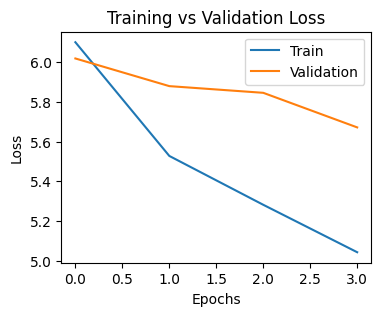

In [42]:
# visualise trai and test loss function
plot_loss_graph(train_losses,test_losses)

We observe a steady decrease in the loss function for both the training and validation datasets, which indicates the efficiency of our model. On the validation dataset, the loss function decreases at a slightly slower rate, which is typical given the complexity of our task. It suggests that the number of epochs could be increased to improve model training further.

Sentence:  That is what I wanted to say in conclusion.
Expected translation:  Esto es lo que deseaba declarar a modo de conclusión.
Es tokens:  ['<sos>', 'por', 'lo', 'que', 'que', 'que', 'que', 'que', 'que', 'que', 'que', 'que', 'que', '<unk>', '.', '<eos>']
En tokens:  ['<sos>', 'that', 'is', 'what', 'i', 'wanted', 'to', 'say', 'in', 'conclusion', '.', '<eos>']


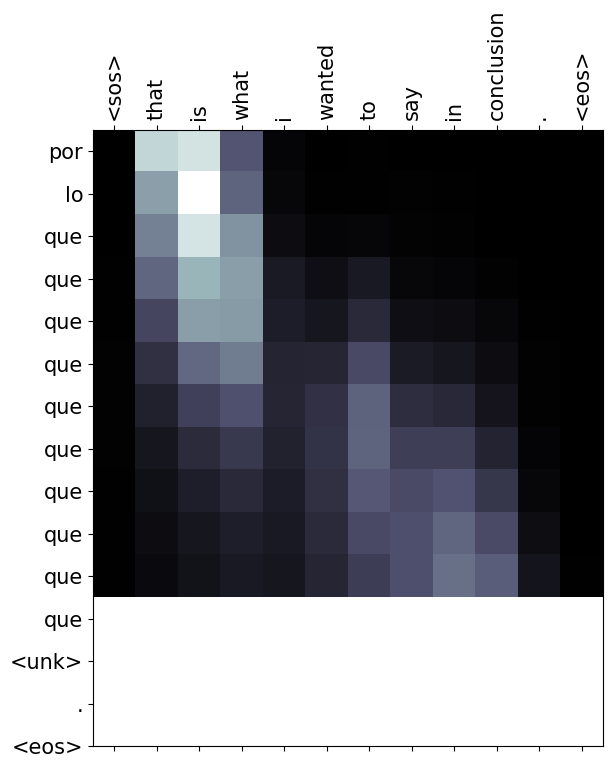

Sentence:  TOPICAL AND URGENT DEBATE
Expected translation:  DEBATE DE ACTUALIDAD Y URGENCIA
Es tokens:  ['<sos>', 'también', ',', 'el', 'de', 'de', 'y', 'el', 'parlamento', 'europeo', '.', '<eos>']
En tokens:  ['<sos>', 'topical', 'and', 'urgent', 'debate', '<eos>']


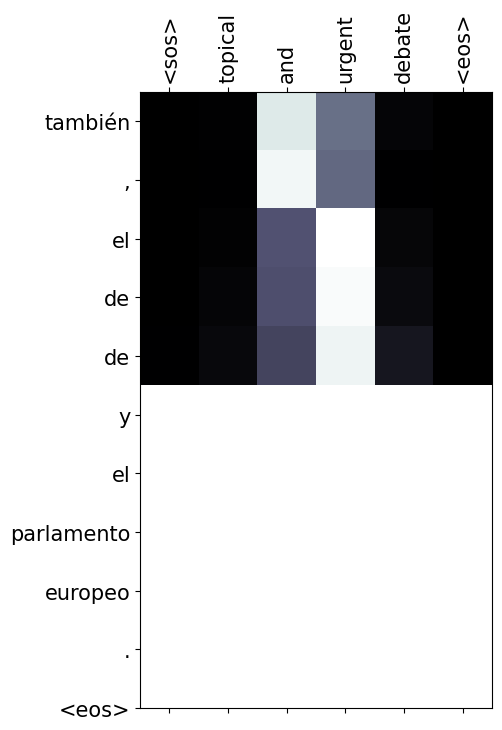

In [43]:
# get several results of translation
compare_translation(0)

compare_translation(5)

Our model is not yet able to produce high-quality translations, but it shows potential for improvement, as indicated by the decreasing loss function. The graph shows that the attention mechanism captures the dependencies between words, though it still requires further refinement. Increasing the amount of training and validation data would likely enhance performance, but we are currently limited by available resources. Nevertheless, the model demonstrates potential for greater effectiveness with larger training datasets.